# Libs

In [133]:
import os
import time
import glob
import json
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Reshape, Activation, Dropout, Flatten
from tensorflow.keras.layers import Embedding, Concatenate, Add, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, normalize

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

import lightgbm as lgb

# Load Data

In [2]:
avi_train_seg = np.load('../Data/avi_train_seg.npy')
trj_train_seg = np.load('../Data/trj_train_seg.npy')
lane_functions = np.load('../Data/lane_functions.npy')

In [3]:
num_lanes = lane_functions.sum(axis=1)
lane_functions = pd.DataFrame(lane_functions,columns=['through','left','right',
                                                      'thr_left','thr_right','u_turn'])
lane_functions['linkIdx'] = np.arange(1,25)
lane_functions['num_lanes'] = num_lanes

# Data Preparation

## Sample Preparation

In [4]:
def get_sample(trj_train_seg):
    data = pd.DataFrame(columns=['linkIdx','datetime','volume'])
    for approach in range(24):
        table = pd.DataFrame(np.zeros((30 * 144,3)),columns=['linkIdx','datetime','volume'])
        table.iloc[:,0] = approach + 1
        for day in range(30):
            if day < 9:
                datetime = [pd.to_datetime('2018010' + str(day + 1)) + pd.Timedelta(i * 10,unit='m') for i in range(144)]
            else:
                datetime = [pd.to_datetime('201801' + str(day + 1)) + pd.Timedelta(i * 10,unit='m') for i in range(144)]
            table.iloc[144 * day:144 * (day + 1),2] = trj_train_seg[day,:,approach]
            table.iloc[144 * day:144 * (day + 1),1] = datetime
        data = pd.concat((data,table))
    data['linkIdx'] = data['linkIdx'].astype('int')
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['volume'] = data['volume'].astype('float')
    return data

In [69]:
X, Y = get_sample(trj_train_seg), get_sample(avi_train_seg)
print("[Basic Stats] num. of samples: {:d}".format(X.shape[0]))

[Basic Stats] num. of samples: 103680


## Feature Engineering

In [6]:
def holiday(x):
    if x.month == 1 and x.day == 1:
        return 1
    else:
        return 0

    
def peak(x):
    if 7 < x.hour < 9:
        return 1
    elif 11 < x.hour < 13:
        return 2
    elif 17 < x.hour < 19:
        return 3
    else:
        return 0

    
def itv_cnt(x, itv_length=600):
    return (x.hour * 3600 + x.minute * 60) // itv_length


def exponential_smoothing(alpha, s):
    s2 = np.zeros(s.shape)
    s2[0] = s[0]
    for i in range(1, len(s2)):
        s2[i] = alpha * s[i] + (1 - alpha) * s2[i - 1]
    return s2


def get_es_volume(trj_train_seg, alpha):
    trj_train_seg_es = trj_train_seg.copy()
    for day_idx in range(30):
        for seg_idx in range(24):
            seq = trj_train_seg[day_idx, :, seg_idx]
            seq_es = exponential_smoothing(alpha, seq)
            trj_train_seg_es[day_idx, :, seg_idx] = seq_es
    return get_sample(trj_train_seg_es)['volume']


def merge_volume_features(X, feature_cols, target_col, aggfuncs=['mean', 'median', 'std']):
    
    for feature in feature_cols:
        for fn in aggfuncs:
            df = X.pivot_table(index='linkIdx',
                               columns=feature,
                               values=target_col,
                               aggfunc=fn).reset_index()
            df.columns = ['linkIdx'] + list(df.columns[1:])
            df = df.melt(id_vars=['linkIdx'],
                         value_vars=list(df.columns[1:]),
                         var_name=feature,
                         value_name=feature + '_' + fn + '_' + target_col)
            df[feature] = pd.to_numeric(df[feature])
            X = pd.merge(X, df, on=['linkIdx',feature])
    return X

In [70]:
# =============================
# Feature Engineering
# =============================

# static attributes
'''
X = pd.merge(X,lane_functions)
'''
X['weekday'] = X['datetime'].map(lambda x:x.weekday())
X['interval'] = X['datetime'].map(lambda x:itv_cnt(x))
X['holiday'] = X['datetime'].map(lambda x:holiday(x))
X['peak'] = X['datetime'].map(lambda x:peak(x))
X['linkIdx'] = X['linkIdx'].astype(int)

# exponenrially smoothed volume
X['volume_es_p6'] = get_es_volume(trj_train_seg, alpha=0.6).values
X['volume_es_p5'] = get_es_volume(trj_train_seg, alpha=0.5).values

# cross volume features
'''
feature_cols = ['through', 'left', 'right', 'thr_left',
                'thr_right', 'u_turn', 'num_lanes',
                'weekday', 'interval', 'holiday', 'peak']
X = merge_volume_features(X, feature_cols, target_col='volume')
X = merge_volume_features(X, feature_cols, target_col='volume_es_p6')
X = merge_volume_features(X, feature_cols, target_col='volume_es_p5')
'''
# penetration rates
X['tmp'] = Y['volume'].values
interval_volume = X.pivot_table(index='interval',
                                values=['volume', 'tmp',
                                        'volume_es_p6', 'volume_es_p5'],
                                aggfunc='sum').reset_index()
interval_volume['penetration'] = interval_volume['volume'] / interval_volume['tmp']
interval_volume['penetration_p6'] = interval_volume['volume_es_p6'] / interval_volume['tmp']
interval_volume['penetration_p6'] = interval_volume['volume_es_p5'] / interval_volume['tmp']
interval_volume.drop(['tmp','volume','volume_es_p5','volume_es_p6'],axis=1,inplace=True)
X = pd.merge(X, interval_volume, on='interval')

# scaled volume
for up_idx, up_col in enumerate(['volume','volume_es_p6','volume_es_p5']):
    for down_idx, down_col in enumerate(['penetration','penetration_p6','penetration_p6']):
        X['scaled_volume_' + str(up_idx) + '_' + str(down_idx)] = X[up_col] / X[down_col]

# correlations & feature count
'''
X.corr().to_excel('../Data/feature_corr.xls')
'''
X.drop('tmp',axis=1,inplace=True)
print("[Basic Stats] dim. of features: {:d}".format(X.shape[1]))

# cat & num features
categorical_features = ['interval', 'weekday', 'holiday', 'peak']
numeric_features = list(set(X.drop(['datetime', 'linkIdx'], axis=1).columns) - set(categorical_features))

[Basic Stats] dim. of features: 20


## Evaluation Metric

In [83]:
def dataset_split(X, Y, split_mode):
    if split_mode is 'random':
        X_train, X_test, y_train, y_test = train_test_split(X.drop(['datetime','linkIdx'], axis=1),
                                                            Y['volume'],
                                                            test_size=0.2, random_state=2020)
    elif split_mode is 'fix_transfer':
        train_idx = X[X['linkIdx'].isin([1,2,3,4,5,6,7,8,24,23,22,21,20,19,18,17,15,16])].index
        test_idx = X[X['linkIdx'].isin([9,10,11,12,13,14])].index
        X_train, X_test = X.drop(['linkIdx', 'datetime'], axis=1).iloc[train_idx, :], X.drop(
            ['linkIdx', 'datetime'], axis=1).iloc[test_idx, :]
        y_train, y_test = Y['volume'].iloc[train_idx], Y['volume'].iloc[test_idx]
        
    elif split_mode is 'random_transfer':
        test_ls = np.unique(np.random.choice(np.arange(1,25),6))
        train_ls = list(set(np.arange(1,25)) - set(test_ls))
        train_idx = X[X['linkIdx'].isin(train_ls)].index
        test_idx = X[X['linkIdx'].isin(test_ls)].index
        X_train, X_test = X.drop(['linkIdx', 'datetime'], axis=1).iloc[train_idx, :], X.drop(
            ['linkIdx', 'datetime'], axis=1).iloc[test_idx, :]
        y_train, y_test = Y['volume'].iloc[train_idx], Y['volume'].iloc[test_idx]
        print("Train links: {:s} | Test links: {:s}".format(str(train_ls), str(test_ls)))
    else:
        print("split mode is wrong !")
        
    return X_train, X_test, y_train, y_test

In [9]:
def mae(y_pred, y_test):
    return np.sum(np.abs(y_pred - y_test) * y_test) / np.sum(y_test)

def mape(y_pred, y_test):
    return np.sum(np.abs(y_pred - y_test)) / np.sum(y_test)

def mspe(y_pred, y_test):
    return np.sum(np.square(y_pred - y_test)) / np.sum(np.square(y_test))

# Distribution EDA

In [39]:
X_train, X_test, y_train, y_test = dataset_split(X, Y, 'random_transfer')

for col in X_train.columns:
    print("[{:s} entropy] {:.2f}".format(col, entropy(X_train[col].iloc[:X_test.shape[-0]],
                                                      X_test[col])))
    #plt.figure()
    #sns.distplot(X_train[col])
    #sns.distplot(X_test[col])
    #plt.savefig('../Data/feature_distribution_shift_figs/' + col + '_dist.png',dpi=200)

Train links: [1, 3, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 22, 24] | Test links: [ 2  4 12 14 21 23]
[volume entropy] inf
[through entropy] 0.23
[left entropy] 0.30
[right entropy] inf
[thr_left entropy] nan
[thr_right entropy] inf
[u_turn entropy] 1.10
[num_lanes entropy] 0.09
[weekday entropy] 0.00
[interval entropy] 0.05
[holiday entropy] 0.00
[peak entropy] nan
[volume_es_p6 entropy] inf
[volume_es_p5 entropy] inf
[through_mean_volume entropy] 0.32
[through_median_volume entropy] 0.44
[through_std_volume entropy] 0.21
[left_mean_volume entropy] 0.32
[left_median_volume entropy] 0.44
[left_std_volume entropy] 0.21
[right_mean_volume entropy] 0.32
[right_median_volume entropy] 0.44
[right_std_volume entropy] 0.21
[thr_left_mean_volume entropy] 0.32
[thr_left_median_volume entropy] 0.44
[thr_left_std_volume entropy] 0.21
[thr_right_mean_volume entropy] 0.32
[thr_right_median_volume entropy] 0.44
[thr_right_std_volume entropy] 0.21
[u_turn_mean_volume entropy] 0.32
[u_turn_

# GANN

In [71]:
def build_dense(h, units, drop=True, norm=True):
    h = Dense(units=units,use_bias=True,activation=None,
              kernel_initializer=he_normal(),
              bias_initializer=constant(0.1),
              kernel_regularizer=l2())(h)
    if norm:
        h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    if drop:
        h = Dropout(rate=0.1)(h)
    return h

In [115]:
def build_transformer(input_shape, embedding_dim, feature_dim):
    x_in = Input(shape=(input_shape,))
    interval = Input(shape=(1,))
    weekday = Input(shape=(1,))
    holiday = Input(shape=(1,))
    peak = Input(shape=(1,))
    
    v_itv = Flatten()(Embedding(input_dim=144,output_dim=int(2 * embedding_dim))(interval))
    v_weekday = Flatten()(Embedding(input_dim=7,output_dim=embedding_dim)(weekday))
    v_holiday = Flatten()(Embedding(input_dim=2,output_dim=embedding_dim)(holiday))
    v_peak = Flatten()(Embedding(input_dim=4,output_dim=embedding_dim)(peak))
    
    vec = Concatenate()([x_in, v_itv, v_weekday, v_holiday, v_peak])
    
    h = build_dense(vec, 256, drop=False, norm=False)
    h = build_dense(h, feature_dim, drop=False, norm=False)
    
    transformer = Model(inputs=[x_in,interval,weekday,
                                holiday,peak],
                        outputs=h,name='transformer')
    return transformer

In [116]:
def build_regressor(feature_dim):
    x_in = Input(shape=(feature_dim,))
    
    def build_resblock(h):
        h1 = build_dense(h, 128, drop=True, norm=False)
        h2 = build_dense(h1, 256, drop=True, norm=False)
        h3 = build_dense(h2, 128, drop=True, norm=False)
        h4 = Add()([h1,h3])
        return h4
    
    
    h = build_resblock(x_in)
    h = build_resblock(h)
    h = build_resblock(h)
    h = Dense(units=1,use_bias=True,
              activation='relu',
              kernel_initializer=he_normal(),
              bias_initializer=constant(0.1),
              kernel_regularizer=l2())(h)
    
    regressor = Model(inputs=x_in,outputs=h,name='regressor')
    return regressor

In [90]:
def build_discriminator(feature_dim):
    x_in = Input(shape=(feature_dim,))
    h = build_dense(x_in, 128, drop=False, norm=True)
    h = build_dense(h, 64, drop=False, norm=True)
    h = build_dense(h, 32, drop=False, norm=True)
    h = Dense(units=1,use_bias=True,
              activation='tanh',
              kernel_initializer='uniform',
              bias_initializer=constant(0.0),
              kernel_regularizer=l2())(h)
    
    discriminator = Model(inputs=x_in,outputs=h,name='discriminator')
    return discriminator

In [91]:
def build_trd(transformer, discriminator, input_shape):
    x_in = Input(shape=(input_shape,))
    interval = Input(shape=(1,))
    weekday = Input(shape=(1,))
    holiday = Input(shape=(1,))
    peak = Input(shape=(1,))
      
    invariant_features = transformer([x_in,interval,weekday,holiday,peak])
    
    class_pred = discriminator(invariant_features)
    
    trd = Model(inputs=[x_in,interval,weekday,holiday,peak],outputs=class_pred)
    return trd

In [76]:
def get_batch(X_source, Y_source, X_target, batch_size):
    while True:
        idx_source = np.random.choice(X_source.shape[0], batch_size, replace=False)
        idx_target = np.random.choice(X_target.shape[0], batch_size, replace=False)
        yield X_source[idx_source], Y_source[idx_source], X_target[idx_target]

In [77]:
def wasserstein(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [78]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == np.round(y_pred)) / len(y_true)

In [79]:
def disc_iteration(iter_idx, cycle_length, split, iter_l, iter_s):
    c = iter_idx % cycle_length
    if c < split:
        return iter_l
    else:
        return iter_s

In [94]:
def train_trd(X_source, Y_source, X_target, attr_cols,
              embedding_dim, feature_dim,
              lr_list, num_iterations,
              cycle_length, split, iter_l, iter_s,
              batch_size, display_num=50):
    
    # data init
    cat_cols = attr_cols
    num_cols = list(set(range(X_source.shape[1])) - set(cat_cols))
    
    # build models
    assert X_source.shape[1] == X_target.shape[1]
    input_shape = len(num_cols)
    transformer = build_transformer(input_shape, embedding_dim, feature_dim)
    regressor = build_regressor(feature_dim=feature_dim)
    discriminator = build_discriminator(feature_dim=feature_dim)
    trd = build_trd(transformer, discriminator, input_shape=input_shape)

    # define optimizer & load lr
    assert len(lr_list) == 3
    opt_trans = Adam(lr_list[0])
    opt_reg = Adam(lr_list[1])
    opt_disc = Adam(lr_list[2])

    # model compile
    transformer.compile(loss='mse', optimizer=opt_trans)
    print("[transformer params] {:d}".format(transformer.count_params()))
    
    regressor.compile(loss='mse', optimizer=opt_reg)
    print("[regressor params] {:d}".format(regressor.count_params()))
    discriminator.trainable = False
    
    trd.compile(loss='binary_crossentropy', optimizer=opt_trans)
    print("[trd params] {:d}".format(trd.count_params()))
    discriminator.trainable = True
    
    discriminator.compile(loss='binary_crossentropy', optimizer=opt_disc)
    print("[discriminator params] {:d}\n".format(discriminator.count_params()))

    # ====================================================================
    # training loop start
    # ====================================================================

    iter_idx = 0
    num_iterations = num_iterations
    log = []

    while iter_idx < num_iterations:

        # train discriminator
        d_iter_idx = 0
        if iter_idx < split or iter_idx % cycle_length == 0:
            num_d_iterations = iter_l
        else:
            num_d_iterations = iter_s

        while d_iter_idx < num_d_iterations:
            batch_source_x, batch_source_y, batch_target_x = next(get_batch(
                X_source, Y_source, X_target, batch_size
            ))
            class_source = np.zeros((batch_source_x.shape[0], 1))
            class_target = np.ones((batch_source_x.shape[0], 1))

            d_batch_x = np.concatenate((batch_source_x, batch_target_x))
            d_batch_y = np.concatenate((class_source, class_target))
            trans_output = transformer.predict([d_batch_x[:,num_cols],
                                                d_batch_x[:,cat_cols[0]],
                                                d_batch_x[:,cat_cols[1]],
                                                d_batch_x[:,cat_cols[2]],
                                                d_batch_x[:,cat_cols[3]]])
            d_loss = discriminator.train_on_batch(trans_output, d_batch_y)
            d_iter_idx += 1
        
        # re-batch
        batch_source_x, batch_source_y, batch_target_x = next(get_batch(
            X_source, Y_source, X_target, batch_size
        ))
        class_source = np.zeros((batch_source_x.shape[0], 1))
        class_target = np.ones((batch_source_x.shape[0], 1))
        
        # train transformer
        discriminator.trainable = False
        t_loss = trd.train_on_batch([batch_target_x[:,num_cols],
                                     batch_target_x[:,cat_cols[0]],
                                     batch_target_x[:,cat_cols[1]],
                                     batch_target_x[:,cat_cols[2]],
                                     batch_target_x[:,cat_cols[3]]], class_source)
        trans_output_reg = transformer.predict([batch_source_x[:,num_cols],
                                                batch_source_x[:,cat_cols[0]],
                                                batch_source_x[:,cat_cols[1]],
                                                batch_source_x[:,cat_cols[2]],
                                                batch_source_x[:,cat_cols[3]]])
        
        # disc acc.
        if iter_idx % display_num == 0:
            trans_output_disc = transformer.predict([batch_target_x[:,num_cols],
                                                     batch_target_x[:,cat_cols[0]],
                                                     batch_target_x[:,cat_cols[1]],
                                                     batch_target_x[:,cat_cols[2]],
                                                     batch_target_x[:,cat_cols[3]]])
            negative_acc = accuracy(class_source, discriminator.predict(trans_output_reg))
            positive_acc = accuracy(class_target, discriminator.predict(trans_output_disc))
            print("[iteration] {:d} | [source acc.] {:.2f}% | [target acc.] {:.2f}%".format(
                    iter_idx, 100 * negative_acc, 100 * positive_acc
                ))
        
        # train regressor
        if iter_idx > 5000:
            r_loss = regressor.train_on_batch(trans_output_reg, batch_source_y)
        else:
            r_loss = -1.0
        
        discriminator.trainable = True

        log.append([d_loss, t_loss, r_loss])
        if iter_idx % display_num == 0:
            print("[iteration] {:d} | [d-loss] {:.2f} | [t-loss] {:.2f} | [r-loss] {:.2f}".format(
                iter_idx, d_loss, t_loss, r_loss
            ))
        iter_idx += 1

    # ====================================================================
    # training loop end
    # ====================================================================
    
    return transformer, regressor, discriminator, log

In [81]:
def one_hot_encoding(X, categorical_features):
    one_hot_enc = OneHotEncoder()
    for feat in categorical_features:
        encoded_matrix = one_hot_enc.fit_transform(X[feat].values.reshape(-1,1)).toarray()
        num_class = encoded_matrix.shape[1]
        one_hot_features = pd.DataFrame()
        for class_ in range(num_class):
            one_hot_features[feat + '_' + str(class_)] = encoded_matrix[:,class_]
        X = pd.concat((X, one_hot_features),axis=1)
    return X

In [86]:
categorical_features = ['weekday', 'holiday', 'peak', 'interval']
numeric_features = list(set(X.columns) - set(categorical_features) - {'linkIdx','datetime'})
X_nn = one_hot_encoding(X, categorical_features)

split_mode = 'fix_transfer'
X_train, X_test, y_train, y_test = dataset_split(X, Y, split_mode)

In [95]:
X_source = X_train.values
Y_source = y_train.values
X_target = X_test.values

num_iterations = 20000
transformer, regressor, discriminator, log = train_trd(X_source, Y_source, X_target,[9,8,10,11],
                                                       embedding_dim=5, feature_dim=20,
                                                       lr_list=[3e-4,3e-4,5e-4],
                                                       num_iterations=num_iterations,
                                                       cycle_length=2000, split=200,
                                                       iter_l=500, iter_s=5,
                                                       batch_size=32, display_num=50)

[transformer params] 11745
[regressor params] 263809
[trd params] 55906
[discriminator params] 44161

[iteration] 0 | [source acc.] 96.88% | [target acc.] 25.00%
[iteration] 0 | [d-loss] 2.44 | [t-loss] 7.58 | [r-loss] -1.00
[iteration] 50 | [source acc.] 21.88% | [target acc.] 87.50%
[iteration] 50 | [d-loss] 0.70 | [t-loss] 5.29 | [r-loss] -1.00
[iteration] 100 | [source acc.] 68.75% | [target acc.] 65.62%
[iteration] 100 | [d-loss] 0.66 | [t-loss] 4.83 | [r-loss] -1.00
[iteration] 150 | [source acc.] 59.38% | [target acc.] 65.62%
[iteration] 150 | [d-loss] 0.62 | [t-loss] 4.41 | [r-loss] -1.00
[iteration] 200 | [source acc.] 53.12% | [target acc.] 68.75%
[iteration] 200 | [d-loss] 0.65 | [t-loss] 4.03 | [r-loss] -1.00
[iteration] 250 | [source acc.] 68.75% | [target acc.] 31.25%
[iteration] 250 | [d-loss] 0.62 | [t-loss] 3.68 | [r-loss] -1.00
[iteration] 300 | [source acc.] 78.12% | [target acc.] 50.00%
[iteration] 300 | [d-loss] 0.66 | [t-loss] 3.42 | [r-loss] -1.00
[iteration] 350

[iteration] 3200 | [source acc.] 78.12% | [target acc.] 59.38%
[iteration] 3200 | [d-loss] 0.69 | [t-loss] 0.76 | [r-loss] -1.00
[iteration] 3250 | [source acc.] 62.50% | [target acc.] 40.62%
[iteration] 3250 | [d-loss] 0.65 | [t-loss] 0.76 | [r-loss] -1.00
[iteration] 3300 | [source acc.] 34.38% | [target acc.] 75.00%
[iteration] 3300 | [d-loss] 0.66 | [t-loss] 0.76 | [r-loss] -1.00
[iteration] 3350 | [source acc.] 71.88% | [target acc.] 21.88%
[iteration] 3350 | [d-loss] 0.59 | [t-loss] 0.74 | [r-loss] -1.00
[iteration] 3400 | [source acc.] 68.75% | [target acc.] 46.88%
[iteration] 3400 | [d-loss] 0.65 | [t-loss] 0.74 | [r-loss] -1.00
[iteration] 3450 | [source acc.] 75.00% | [target acc.] 50.00%
[iteration] 3450 | [d-loss] 0.62 | [t-loss] 0.78 | [r-loss] -1.00
[iteration] 3500 | [source acc.] 59.38% | [target acc.] 65.62%
[iteration] 3500 | [d-loss] 0.74 | [t-loss] 0.77 | [r-loss] -1.00
[iteration] 3550 | [source acc.] 53.12% | [target acc.] 50.00%
[iteration] 3550 | [d-loss] 0.68 |

[iteration] 6400 | [source acc.] 87.50% | [target acc.] 34.38%
[iteration] 6400 | [d-loss] 0.64 | [t-loss] 0.77 | [r-loss] 8692.28
[iteration] 6450 | [source acc.] 43.75% | [target acc.] 71.88%
[iteration] 6450 | [d-loss] 0.72 | [t-loss] 0.75 | [r-loss] 4380.21
[iteration] 6500 | [source acc.] 46.88% | [target acc.] 75.00%
[iteration] 6500 | [d-loss] 0.68 | [t-loss] 0.76 | [r-loss] 5041.28
[iteration] 6550 | [source acc.] 68.75% | [target acc.] 37.50%
[iteration] 6550 | [d-loss] 0.63 | [t-loss] 0.76 | [r-loss] 5488.75
[iteration] 6600 | [source acc.] 75.00% | [target acc.] 59.38%
[iteration] 6600 | [d-loss] 0.67 | [t-loss] 0.75 | [r-loss] 4910.80
[iteration] 6650 | [source acc.] 46.88% | [target acc.] 81.25%
[iteration] 6650 | [d-loss] 0.68 | [t-loss] 0.76 | [r-loss] 7111.66
[iteration] 6700 | [source acc.] 75.00% | [target acc.] 40.62%
[iteration] 6700 | [d-loss] 0.63 | [t-loss] 0.75 | [r-loss] 7209.75
[iteration] 6750 | [source acc.] 65.62% | [target acc.] 46.88%
[iteration] 6750 | [

[iteration] 9550 | [source acc.] 37.50% | [target acc.] 87.50%
[iteration] 9550 | [d-loss] 0.63 | [t-loss] 0.74 | [r-loss] 6777.05
[iteration] 9600 | [source acc.] 50.00% | [target acc.] 59.38%
[iteration] 9600 | [d-loss] 0.66 | [t-loss] 0.73 | [r-loss] 4486.93
[iteration] 9650 | [source acc.] 75.00% | [target acc.] 53.12%
[iteration] 9650 | [d-loss] 0.73 | [t-loss] 0.73 | [r-loss] 4449.49
[iteration] 9700 | [source acc.] 68.75% | [target acc.] 46.88%
[iteration] 9700 | [d-loss] 0.69 | [t-loss] 0.73 | [r-loss] 4809.68
[iteration] 9750 | [source acc.] 78.12% | [target acc.] 34.38%
[iteration] 9750 | [d-loss] 0.65 | [t-loss] 0.74 | [r-loss] 6471.61
[iteration] 9800 | [source acc.] 75.00% | [target acc.] 37.50%
[iteration] 9800 | [d-loss] 0.64 | [t-loss] 0.74 | [r-loss] 4625.67
[iteration] 9850 | [source acc.] 43.75% | [target acc.] 81.25%
[iteration] 9850 | [d-loss] 0.68 | [t-loss] 0.75 | [r-loss] 5125.86
[iteration] 9900 | [source acc.] 96.88% | [target acc.] 21.88%
[iteration] 9900 | [

[iteration] 12650 | [source acc.] 62.50% | [target acc.] 50.00%
[iteration] 12650 | [d-loss] 0.68 | [t-loss] 0.73 | [r-loss] 6327.48
[iteration] 12700 | [source acc.] 81.25% | [target acc.] 46.88%
[iteration] 12700 | [d-loss] 0.67 | [t-loss] 0.73 | [r-loss] 6149.95
[iteration] 12750 | [source acc.] 31.25% | [target acc.] 75.00%
[iteration] 12750 | [d-loss] 0.68 | [t-loss] 0.79 | [r-loss] 7590.53
[iteration] 12800 | [source acc.] 75.00% | [target acc.] 56.25%
[iteration] 12800 | [d-loss] 0.67 | [t-loss] 0.73 | [r-loss] 7676.10
[iteration] 12850 | [source acc.] 34.38% | [target acc.] 71.88%
[iteration] 12850 | [d-loss] 0.73 | [t-loss] 0.75 | [r-loss] 5996.61
[iteration] 12900 | [source acc.] 75.00% | [target acc.] 31.25%
[iteration] 12900 | [d-loss] 0.63 | [t-loss] 0.74 | [r-loss] 7823.95
[iteration] 12950 | [source acc.] 78.12% | [target acc.] 40.62%
[iteration] 12950 | [d-loss] 0.66 | [t-loss] 0.75 | [r-loss] 5917.41
[iteration] 13000 | [source acc.] 65.62% | [target acc.] 59.38%
[iter

[iteration] 15750 | [source acc.] 75.00% | [target acc.] 62.50%
[iteration] 15750 | [d-loss] 0.60 | [t-loss] 0.76 | [r-loss] 4501.57
[iteration] 15800 | [source acc.] 75.00% | [target acc.] 56.25%
[iteration] 15800 | [d-loss] 0.59 | [t-loss] 0.77 | [r-loss] 2573.09
[iteration] 15850 | [source acc.] 46.88% | [target acc.] 53.12%
[iteration] 15850 | [d-loss] 0.66 | [t-loss] 0.76 | [r-loss] 5339.25
[iteration] 15900 | [source acc.] 59.38% | [target acc.] 53.12%
[iteration] 15900 | [d-loss] 0.58 | [t-loss] 0.76 | [r-loss] 5039.63
[iteration] 15950 | [source acc.] 62.50% | [target acc.] 56.25%
[iteration] 15950 | [d-loss] 0.68 | [t-loss] 0.75 | [r-loss] 4978.31
[iteration] 16000 | [source acc.] 62.50% | [target acc.] 78.12%
[iteration] 16000 | [d-loss] 0.65 | [t-loss] 0.75 | [r-loss] 3709.85
[iteration] 16050 | [source acc.] 68.75% | [target acc.] 59.38%
[iteration] 16050 | [d-loss] 0.65 | [t-loss] 0.75 | [r-loss] 5031.08
[iteration] 16100 | [source acc.] 37.50% | [target acc.] 81.25%
[iter

[iteration] 18850 | [source acc.] 34.38% | [target acc.] 59.38%
[iteration] 18850 | [d-loss] 0.71 | [t-loss] 0.75 | [r-loss] 5150.20
[iteration] 18900 | [source acc.] 46.88% | [target acc.] 56.25%
[iteration] 18900 | [d-loss] 0.68 | [t-loss] 0.73 | [r-loss] 5034.47
[iteration] 18950 | [source acc.] 34.38% | [target acc.] 90.62%
[iteration] 18950 | [d-loss] 0.78 | [t-loss] 0.76 | [r-loss] 6251.14
[iteration] 19000 | [source acc.] 81.25% | [target acc.] 53.12%
[iteration] 19000 | [d-loss] 0.60 | [t-loss] 0.74 | [r-loss] 4268.25
[iteration] 19050 | [source acc.] 59.38% | [target acc.] 56.25%
[iteration] 19050 | [d-loss] 0.60 | [t-loss] 0.76 | [r-loss] 4740.73
[iteration] 19100 | [source acc.] 65.62% | [target acc.] 56.25%
[iteration] 19100 | [d-loss] 0.63 | [t-loss] 0.74 | [r-loss] 3954.05
[iteration] 19150 | [source acc.] 65.62% | [target acc.] 65.62%
[iteration] 19150 | [d-loss] 0.61 | [t-loss] 0.76 | [r-loss] 6080.97
[iteration] 19200 | [source acc.] 43.75% | [target acc.] 56.25%
[iter

Text(0, 0.5, 'T/D Loss')

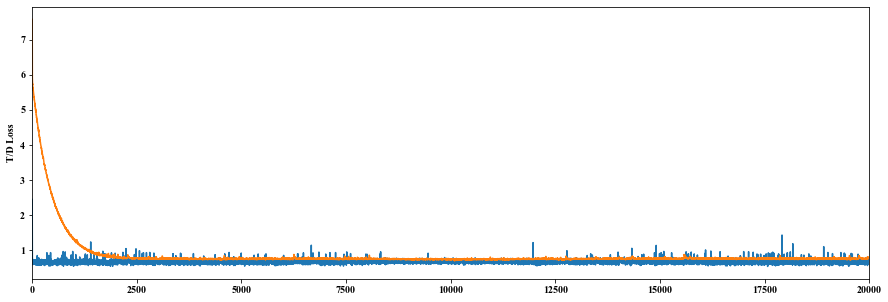

In [113]:
plt.rc('font',family='Times New Roman')
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(111)
ax.plot(np.array(log)[:,0])
ax.plot(np.array(log)[:,1])
plt.xlim([0, num_iterations])
plt.ylabel('T/D Loss')

ax1 = ax.twinx()
ax1.plot(np.arange(5000,num_iterations),np.sqrt(np.array(log)[5000:,2]),c='g')
plt.ylabel('R Loss')
plt.ylim([30,120])

In [97]:
feat_test = transformer.predict([X_test[numeric_features],
                                 X_test['interval'],
                                 X_test['weekday'],
                                 X_test['holiday'],
                                 X_test['peak']])
y_pred = regressor.predict(feat_test).reshape(-1)

print("[TRD] mae: {:.2f} | mape: {:.2f}% | mspe: {:.2f}%".format(
    mae(y_pred, y_test),
    100 * mape(y_pred, y_test), 100 * mspe(y_pred, y_test)))

[TRD] mae: 77.38 | mape: 61.29% | mspe: 36.02%


In [98]:
feat_train = transformer.predict([X_train[numeric_features],
                                  X_train['interval'],
                                  X_train['weekday'],
                                  X_train['holiday'],
                                  X_train['peak']])
feat = np.concatenate((feat_train, feat_test),axis=0)
np.save('../Data/invariant_feature_dann.npy',feat)

In [126]:
transformer.save('../Data/transformer.h5')
discriminator.save('../Data/discriminator.h5')
regressor.save('../Data/original_regressor.h5')

# Regressor from scratch

In [122]:
knn = KNeighborsRegressor(n_neighbors=10,weights='distance',n_jobs=-1)
knn = knn.fit(feat_train,y_train)

In [123]:
y_pred = knn.predict(feat_test)
print("[kNN] mae: {:.2f} | mape: {:.2f}% | mspe: {:.2f}%".format(
    mae(y_pred, y_test),
    100 * mape(y_pred,y_test), 100 * mspe(y_pred, y_test)))

[kNN] mae: 69.05 | mape: 62.09% | mspe: 37.06%


In [128]:
X_new_train = np.concatenate((feat_train,X_train.values),axis=1)
X_new_test = np.concatenate((feat_test,X_test.values),axis=1)

In [129]:
train_data = lgb.Dataset(X_new_train, y_train)

params = {
    'objective':'regression',
    'boosting':'gbdt',
    'num_rounds':10000,
    'learning_rate':0.01,
    'max_depth':8,
    'num_leaves':80,
    'bagging_fraction':0.8,
    'bagging_freq':50,
    'verbose':2
}

gbm = lgb.train(params, train_data)

y_pred = gbm.predict(X_new_test)

print("[LightGBM] mae: {:.2f} | mape: {:.2f}% | mspe: {:.2f}%".format(
    mae(y_pred, y_test),
    100 * mape(y_pred,y_test), 100 * mspe(y_pred, y_test)))

[LightGBM] mae: 55.76 | mape: 52.43% | mspe: 27.85%


In [150]:
def build_regressor(input_shape, num_blocks):
    x_in = Input(shape=(input_shape,))
    h = Reshape((input_shapet, 1))(x_in)
    
    h = Conv1D(32,kernel_size=10,)
    def build_resblock(h):
        h1 = build_dense(h, 512, drop=False, norm=False)
        h2 = build_dense(h1, 256, drop=False, norm=False)
        h3 = build_dense(h2, 512, drop=False, norm=False)
        h4 = Add()([h1,h3])
        return h4
    
    h = build_dense(x_in, 128, drop=False, norm=False)
    for i in range(num_blocks):
        h = build_resblock(h)
        
    o = build_dense(h, 1, drop=False, norm=False)
    
    reg = Model(inputs=x_in, outputs=o)
    return reg